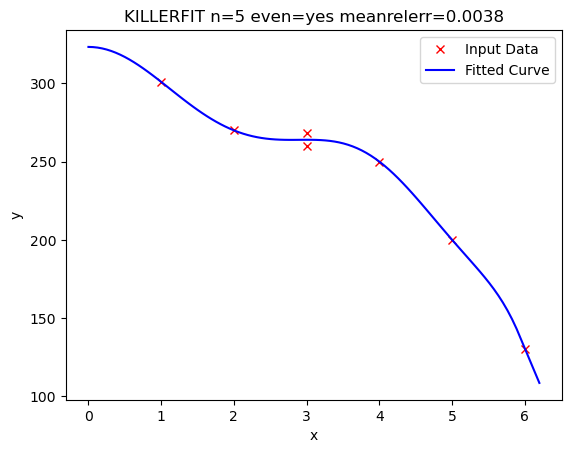

Polynomial coefficients: [-2.45965845e-07  2.37175485e-05 -8.39627833e-04  1.25786180e-02
 -8.34224581e-02  5.77877026e+00]
Mean relative error: 0.0037883136514143345
Max relative error: 0.015268058578241896


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def killerfit(x, y, xg, fitpar=None):
    """
    Fit and interpolate data using log-polynomial regression.
    
    Parameters:
        x (array): Input x-coordinates.
        y (array): Input y-coordinates (must be positive).
        xg (array): Output x grid for interpolation.
        fitpar (dict, optional): Dictionary containing fitting parameters.
            - 'plo': Plot results ('yes' or 'no'). Default is 'yes'.
            - 'extend': Extend interpolation beyond bounds ('yes' or 'no'). Default is 'no'.
            - 'n': Order of polynomial. Default is 6.
            - 'even': Force polynomial to be even ('yes' or 'no'). Default is 'yes'.
    
    Returns:
        yfit (array): Interpolated values at xg.
        fitpar (dict): Updated dictionary with fitting details.
    """
    # Default parameters
    if fitpar is None:
        fitpar = {}
    fitpar.setdefault('plo', 'yes')
    fitpar.setdefault('extend', 'no')
    fitpar.setdefault('n', 6)
    fitpar.setdefault('even', 'yes')
    
    # Add a mirror point about x=0 to ensure the fit well extends to x=0
    x = np.insert(x,0,-1*x[0])
    y = np.insert(y,0,y[0])
    
    # Ensure y is finite and positive
    ok = np.isfinite(y)
    x = np.asarray(x)
    y = np.asarray(y)


    
    # Prepare x and xg based on the 'even' parameter
    xin = x**2 if fitpar['even'] == 'yes' else x
    xgin = xg**2 if fitpar['even'] == 'yes' else xg

    # Fit a polynomial to the log of the data
    p = np.polyfit(xin[ok], np.log(y[ok]), fitpar['n'])

    # Interpolate within bounds
    xgok = (xg >= x.min()) & (xg <= x.max())
    yfit = np.full_like(xg, np.nan, dtype=float)
    yfit[xgok] = np.exp(np.polyval(p, xgin[xgok]))

    # Save fitted polynomial coefficients
    fitpar['p'] = p

    # Handle extrapolation if 'extend' is enabled
    if fitpar['extend'] == 'yes':
        lo = xg < x.min()
        hi = xg > x.max()

        # Extrapolate high-end using the slope
        if np.sum(xgok) > 1:  # Ensure at least two valid points exist for slope calculation
            slope = (yfit[xgok][-1] - yfit[xgok][-2]) / (xg[xgok][-1] - xg[xgok][-2])
            slope = max(0.5 * yfit[xgok][-1] / (xg[xgok][-1] - xg[xgok][-2]), slope) if slope >= 0 else slope
            yfit[hi] = yfit[xgok][-1] + slope * (xg[hi] - xg[xgok][-1])

        # Extrapolate low-end if needed
        
        yfit[lo] = yfit[xgok].flatten()[0]


    # Compute errors
    yfitin = np.exp(np.polyval(p, xin))
    fitpar['meanrelerr'] = np.mean(np.abs(y[ok] - yfitin[ok]) / y[ok])
    fitpar['maxrelerr'] = np.max(np.abs(y[ok] - yfitin[ok]) / y[ok])

    # Plot results
    if fitpar['plo'] == 'yes':
        plt.plot(x[1:], y[1:], 'rx', label='Input Data')
        plt.plot(xg, yfit, 'b', label='Fitted Curve')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f"KILLERFIT n={fitpar['n']} even={fitpar['even']} meanrelerr={fitpar['meanrelerr']:.4f}")
        plt.legend()
        plt.show()

    return yfit, fitpar


# Sample data
x = np.array([1, 2, 3, 3, 4, 5, 6])
y = np.array([301,270,260,268,250,200,130])  # Exponential growth
xg = np.linspace(0, 6.2, 100)  # Interpolation grid

# Fit and interpolate
fitpar = {'plo': 'yes', 'extend': 'yes', 'n': 5, 'even': 'yes'}
yfit, fitpar_updated = killerfit(x, y, xg, fitpar)

# Print results
print("Polynomial coefficients:", fitpar_updated['p'])
print("Mean relative error:", fitpar_updated['meanrelerr'])
print("Max relative error:", fitpar_updated['maxrelerr'])
